In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

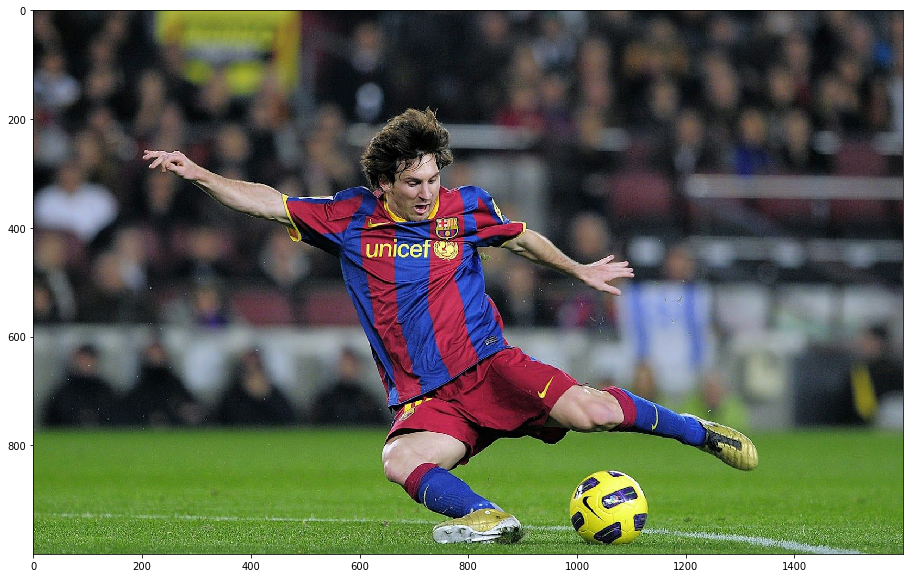

In [9]:
img = cv2.imread('./imgdata/messi.jpg')
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=[16, 10])
plt.imshow(rgb)
plt.show()

## 直方图反向投影

目的：根据感兴趣图像和目标查找图像的2D直方图，得到目标查找图像上与感兴趣图像相似的区域。例如，我想在上面的而图像中把草地部分的图像提取出来，那么我只需要再找一张画面全是绿色草地的图像，对他们进行直方图方向投影，即可达到目的。此时`messi.jpg`就是我们的目标查找图像，而全是绿色草地的图像就是感兴趣图像。

之所以要使用2D直方图，是因为一个物体的颜色要比它的灰度能更好的被用来进行图像分割与对象识别。

In [3]:
img.shape

(1000, 1600, 3)

### 感兴趣图像

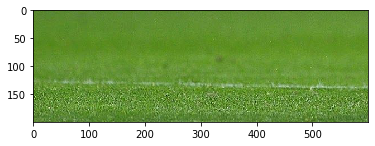

In [10]:
slice_h = slice(800, None)
slice_w = slice(0, 600)
img_roi = rgb[slice_h, slice_w, :]
plt.imshow(img_roi)
plt.show()

`cv2.normalize(src, dst[, alpha[, beta[, norm_type[, dtype[, mask]]]]])`

+ src: input array
+ dst: output array of the same size as src
+ alpha: norm value to normalize to or the lower range boundary in case of the range normalization.
+ beta: upper range boundary in case of the range normalization; it is not used for the norm normalization.
+ norm_type: opencv提供了四种不同的归一化方式，分别为NORM_INF, NORM_MINMAX,NORM_L1和NORM_L2

`cv2.threshold (src, thresh, maxval, type)`

+ src：源图片，必须是单通道
+ thresh：阈值，取值范围0～255
+ maxval：**填充色，取值范围0～255**
+ type：阈值类型，具体见下表

| type | 小于阈值的像素点 | 大于阈值的像素点 |
| ---- | ---- | ---- |
| 0 | 置0 | 置填充色|
| 1 | 置填充色 | 置0|
| 2 | 保持原色 | 置灰色|
|3 | 置0 | 保持原色|
|4 | 保持原色 | 置0 |

## numpy版直方图反向投影

/home/dk/anaconda3/envs/fun/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


ratio shape: (180, 256)
B shape: (1600000,)
B shape: (1000, 1600)


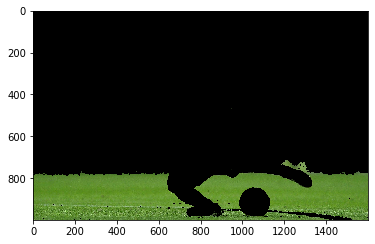

In [14]:
# 分别将两幅图像的颜色模式转换为HSV
img_tar = cv2.imread('./imgdata/messi.jpg')
img_roi = img_tar[slice_h, slice_w, :]
hsv_tar = cv2.cvtColor(img_tar, cv2.COLOR_BGR2HSV)
hsv_roi = cv2.cvtColor(img_roi, cv2.COLOR_BGR2HSV)

# 分别计算两幅图像的2D直方图
hist_roi = cv2.calcHist([hsv_roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
hist_tar = cv2.calcHist([hsv_tar], [0, 1], None, [180, 256], [0, 180, 0, 256])

# 计算两幅图像的2D直方图对应像素的相似程度
ratio = hist_roi / hist_tar
h_tar, s_tar, v_tar = cv2.split(hsv_tar)
print(f'ratio shape: {ratio.shape}')

# 计算目标图像中的每个像素与感兴趣图像中的像素相似的概率【也可以认为是计算目标图像中的像素属于感兴趣图像的概率】
B = ratio[h_tar.ravel(), s_tar.ravel()]
# 因为期望B中的每个值表示概率，因此要限制它的最大值不超过1
B = np.minimum(B, 1)
print(f'B shape: {B.shape}')
B = B.reshape(hsv_tar.shape[:2])
print(f'B shape: {B.shape}')

# 这里使用圆盘卷积核把分散的点连接到一起
disc_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
B = cv2.filter2D(B, -1, disc_kernel)
B = np.uint8(B)

# 将B中的元素值scale到0-255之间
cv2.normalize(src=B, dst=B, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
# 像素值小于50的置为0，大于50的置为255
thresh_val, thresh = cv2.threshold(B, thresh=50, maxval=255, type=0)

# 分别对目标图像的三个通道使用threshold mask
thresh = cv2.merge((thresh, thresh, thresh))
res = cv2.bitwise_and(img_tar, thresh)

cv2.cvtColor(res, cv2.COLOR_BGR2RGB, res)
plt.imshow(res)
plt.show()

In [15]:
disc_kernel

array([[0, 0, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [0, 0, 1, 0, 0]], dtype=uint8)

## 使用`cv2.calcBackProject()`实现直方图反向投影

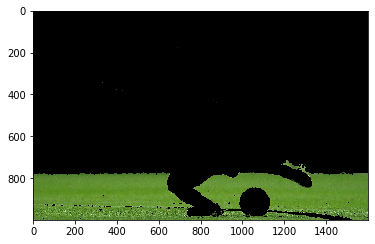

In [13]:
img_tar = cv2.imread('./imgdata/messi.jpg')
img_roi = img_tar[slice_h, slice_w, :]
hsv_tar = cv2.cvtColor(img_tar, cv2.COLOR_BGR2HSV)
hsv_roi = cv2.cvtColor(img_roi, cv2.COLOR_BGR2HSV)

hist_roi = cv2.calcHist([hsv_roi], [0, 1], None, [180, 256], [0, 180, 0, 256])
cv2.normalize(hist_roi, hist_roi, 0, 255, cv2.NORM_MINMAX)
dst = cv2.calcBackProject([hsv_tar], [0, 1], hist_roi, [0,180,0,256], 1)

# 这里使用圆盘卷积核把分散的点连接到一起
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
dst = cv2.filter2D(dst, -1, disc)

# 分别对目标图像的三个通道使用threshold mask
ret, thresh = cv2.threshold(dst, 50, 255, 0)
thresh = cv2.merge((thresh, thresh, thresh))
res = cv2.bitwise_and(img_tar, thresh)

cv2.cvtColor(res, cv2.COLOR_BGR2RGB, res)
plt.imshow(res)
plt.show()